In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from importlib import reload
import skimage.io
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

# local code
import sys
sys.path.append("../source/")

In [2]:
# DATA PATHS
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/"
czi_path = f"{ROOT_DIR}3x3-extract-Scene6-07-14to15_stitched.czi"
trackmate_path = f"{ROOT_DIR}spots.csv"
tiff_path = f"{ROOT_DIR}composite.tif"

# global vars
SCALING = 1.4633
MINUTES_PER_FRAME = 25

In [3]:
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

print(df.shape)
df.head()

(9160, 46)


LABEL     ID  TRACK_ID   QUALITY   POSITION_X  POSITION_Y  POSITION_Z  \
0  ID11264  11264       0.0  0.621232    13.624937  735.647836         0.0   
1  ID11265  11265       1.0  0.619526   799.905202  718.453691         0.0   
2  ID11266  11266       2.0  0.576961  1070.928972  211.395927         0.0   
3  ID11267  11267       3.0  0.553324  1166.407990  861.873077         0.0   
4  ID11268  11268       NaN  0.542137  1011.519677   23.141251         0.0   

   POSITION_T  FRAME    RADIUS  ...  ELLIPSE_X0  ELLIPSE_Y0  ELLIPSE_MAJOR  \
0         0.0      0  8.959511  ...   -0.019652    0.039077       5.524627   
1         0.0      0  4.922364  ...   -0.002425   -0.023146       3.073098   
2         0.0      0  9.868752  ...    0.008092   -0.016601       4.390829   
3         0.0      0  2.901323  ...   -0.017963   -0.028914       2.645642   
4         0.0      0  9.209876  ...    0.015370    0.013344       4.075843   

   ELLIPSE_MINOR  ELLIPSE_THETA  ELLIPSE_ASPECTRATIO       AREA  PERIMETER  \
0       4.101917      -1.010200             1.346840  70.287885  33.467752   
1       2.739228       1.421361             1.121885  25.920117  20.999318   
2       4.023751       0.567798             1.091228  54.875924  27.633858   
3       2.177968       1.307088             1.214729  17.747107  18.099917   
4       3.833116       1.674520             1.063323  48.571030  27.242518   

   CIRCULARITY  SOLIDITY  
0     0.788565  0.943574  
1     0.738646  0.932773  
2     0.903043  0.975104  
3     0.680745  0.894118  
4     0.822418  0.941176  

[5 rows x 46 columns]

In [4]:
# load the tiff into memory
tiff = skimage.io.imread(tiff_path)
tiff.shape

(49, 1329, 1801, 3)

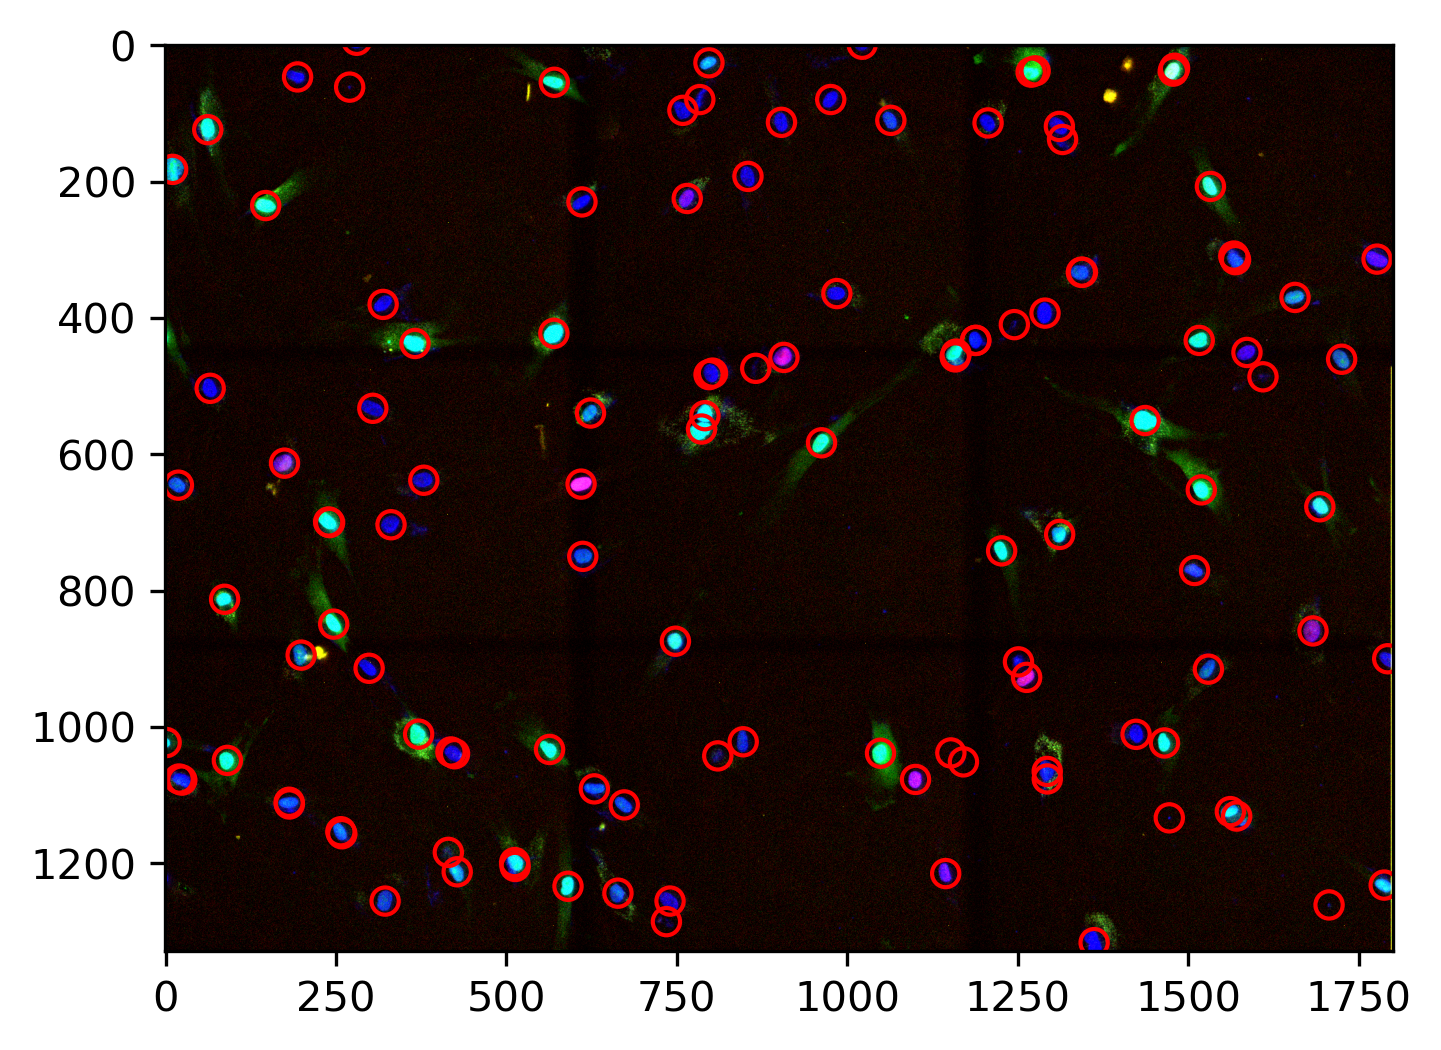

In [5]:
# check scaling
frame0 = df[df['FRAME'] == df['FRAME'].min()]

plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots()
ax.imshow(tiff[0, :, :, :])

for idx, spot in frame0.iterrows():
    x = spot['POSITION_X'] * SCALING
    y = spot['POSITION_Y'] * SCALING
    
    spot_blob = plt.Circle((x, y), 20, color='r', fill=False)
    ax.add_patch(spot_blob)

In [6]:
# a few quick exclusions based on size and track length

min_track_length = 20
min_mean_size = 9

print(f"{df.shape=}")
print(f"{df['TRACK_ID'].nunique()=}")

df = df.sort_values(by=['TRACK_ID', 'FRAME'])

df['STEP'] =  df.groupby('TRACK_ID').transform('cumcount')
df['MAX_STEP'] =  df.groupby('TRACK_ID')['STEP'].transform('max')


####### perform all filtering on a temporary dataframe
tmp = df.copy()

filtered = df.groupby('TRACK_ID')['STEP'].max().reset_index()
filtered = filtered[filtered['STEP'] > min_track_length]
tmp = tmp[tmp['TRACK_ID'].isin(filtered['TRACK_ID'])]

print(f"\nfilter 1:")
print(f"\t{tmp.shape=}")
print(f"\t{tmp['TRACK_ID'].nunique()=}")

# df.loc[:, 'MEAN_RADIUS'] =  df.groupby(['TRACK_ID'])['RADIUS'].mean()

filtered = tmp.groupby('TRACK_ID')['RADIUS'].mean().reset_index()
filtered = filtered[filtered['RADIUS'] > min_mean_size]
tmp = tmp[tmp['TRACK_ID'].isin(filtered['TRACK_ID'])]

print(f"\nfilter 2:")
print(f"\t{tmp.shape=}")
print(f"\t{tmp['TRACK_ID'].nunique()=}")


df = tmp.copy()
df = df.sort_values(by=['TRACK_ID', 'FRAME'])

filename = f"{ROOT_DIR}filtered_spots.csv"
df.to_csv(filename, index=False)
print(f"{filename=}")

df.shape=(9160, 46)
df['TRACK_ID'].nunique()=738

filter 1:
	tmp.shape=(4462, 48)
	tmp['TRACK_ID'].nunique()=128

filter 2:
	tmp.shape=(4069, 48)
	tmp['TRACK_ID'].nunique()=114
filename='/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/filtered_spots.csv'


frame=16
int(xpos)=1236
int(ypos)=760
int(track)=232


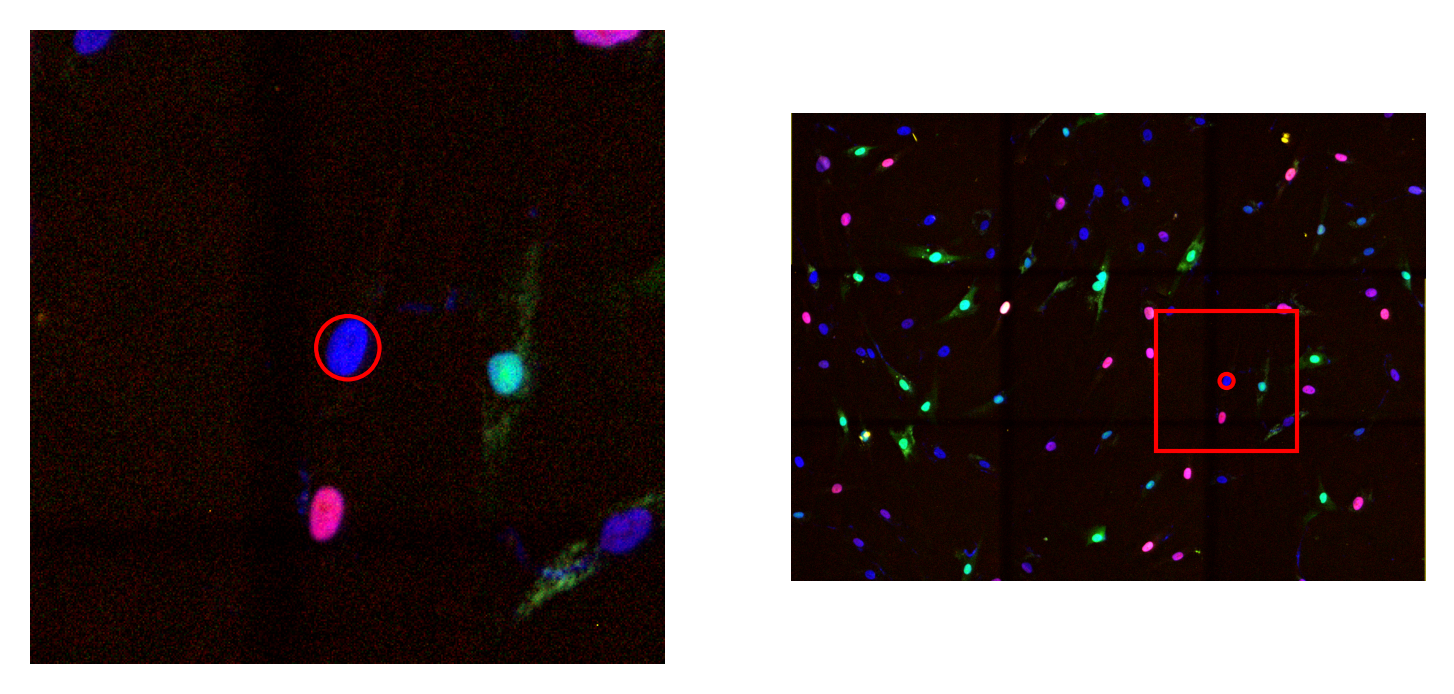

In [7]:
def get_images(tiff, frame, xpos, ypos, xwin=50, ywin=50):
    """A function to return a small frame of from a position
    at a specific time from a movie
    
    expects input shape (time, y, x, 3) for RGB image
    """
    f, m, n, c = tiff.shape
    
    xmin = int(xpos - xwin)
    xmax = int(xpos + xwin)
    ymin = int(ypos - ywin)
    ymax = int(ypos + ywin)
    
    spot_x, spot_y = xwin, ywin
    
    # handle boundaries
    if xmin < 0:
        spot_x = spot_x + xmin
        xmin = 0 
    
    if xmax > n:
        xmax = n
        
    if ymin < 0:
        spot_y = spot_y + ymin
        ymin = 0

    if ymax > m:
        ymax = m

    img = tiff[frame, ymin:ymax, xmin:xmax, :]
    return img, (spot_x, spot_y)

     
rand_row = df.sample(1)
track = rand_row['TRACK_ID'].values[0]
xpos = rand_row['POSITION_X'].values[0] * SCALING
ypos = rand_row['POSITION_Y'].values[0] * SCALING
frame = rand_row['FRAME'].values[0]

print(f"{frame=}")
print(f"{int(xpos)=}")
print(f"{int(ypos)=}")
print(f"{int(track)=}")

xwin = 200
ywin = 200
nucleus_size = 20
img, spot_center = get_images(tiff, frame, xpos, ypos, xwin, ywin)

plt.rcParams['figure.dpi'] = 300
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img)
ax1.axis('off')
subset_shape = img.shape
spot_blob = plt.Circle((spot_center[0], spot_center[1]), nucleus_size, color='r', fill=False)
ax1.add_patch(spot_blob)

ax2.imshow(tiff[frame, :, :, :])
ax2.axis('off')
spot_blob = plt.Circle((xpos, ypos), nucleus_size, color='r', fill=False)
ax2.add_patch(spot_blob)

# Create a Rectangle patch
rect = patches.Rectangle((xpos-xwin, ypos-ywin), xwin*2, ywin*2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax2.add_patch(rect)

int(rand_track)=321
tmp.shape=(33, 50)


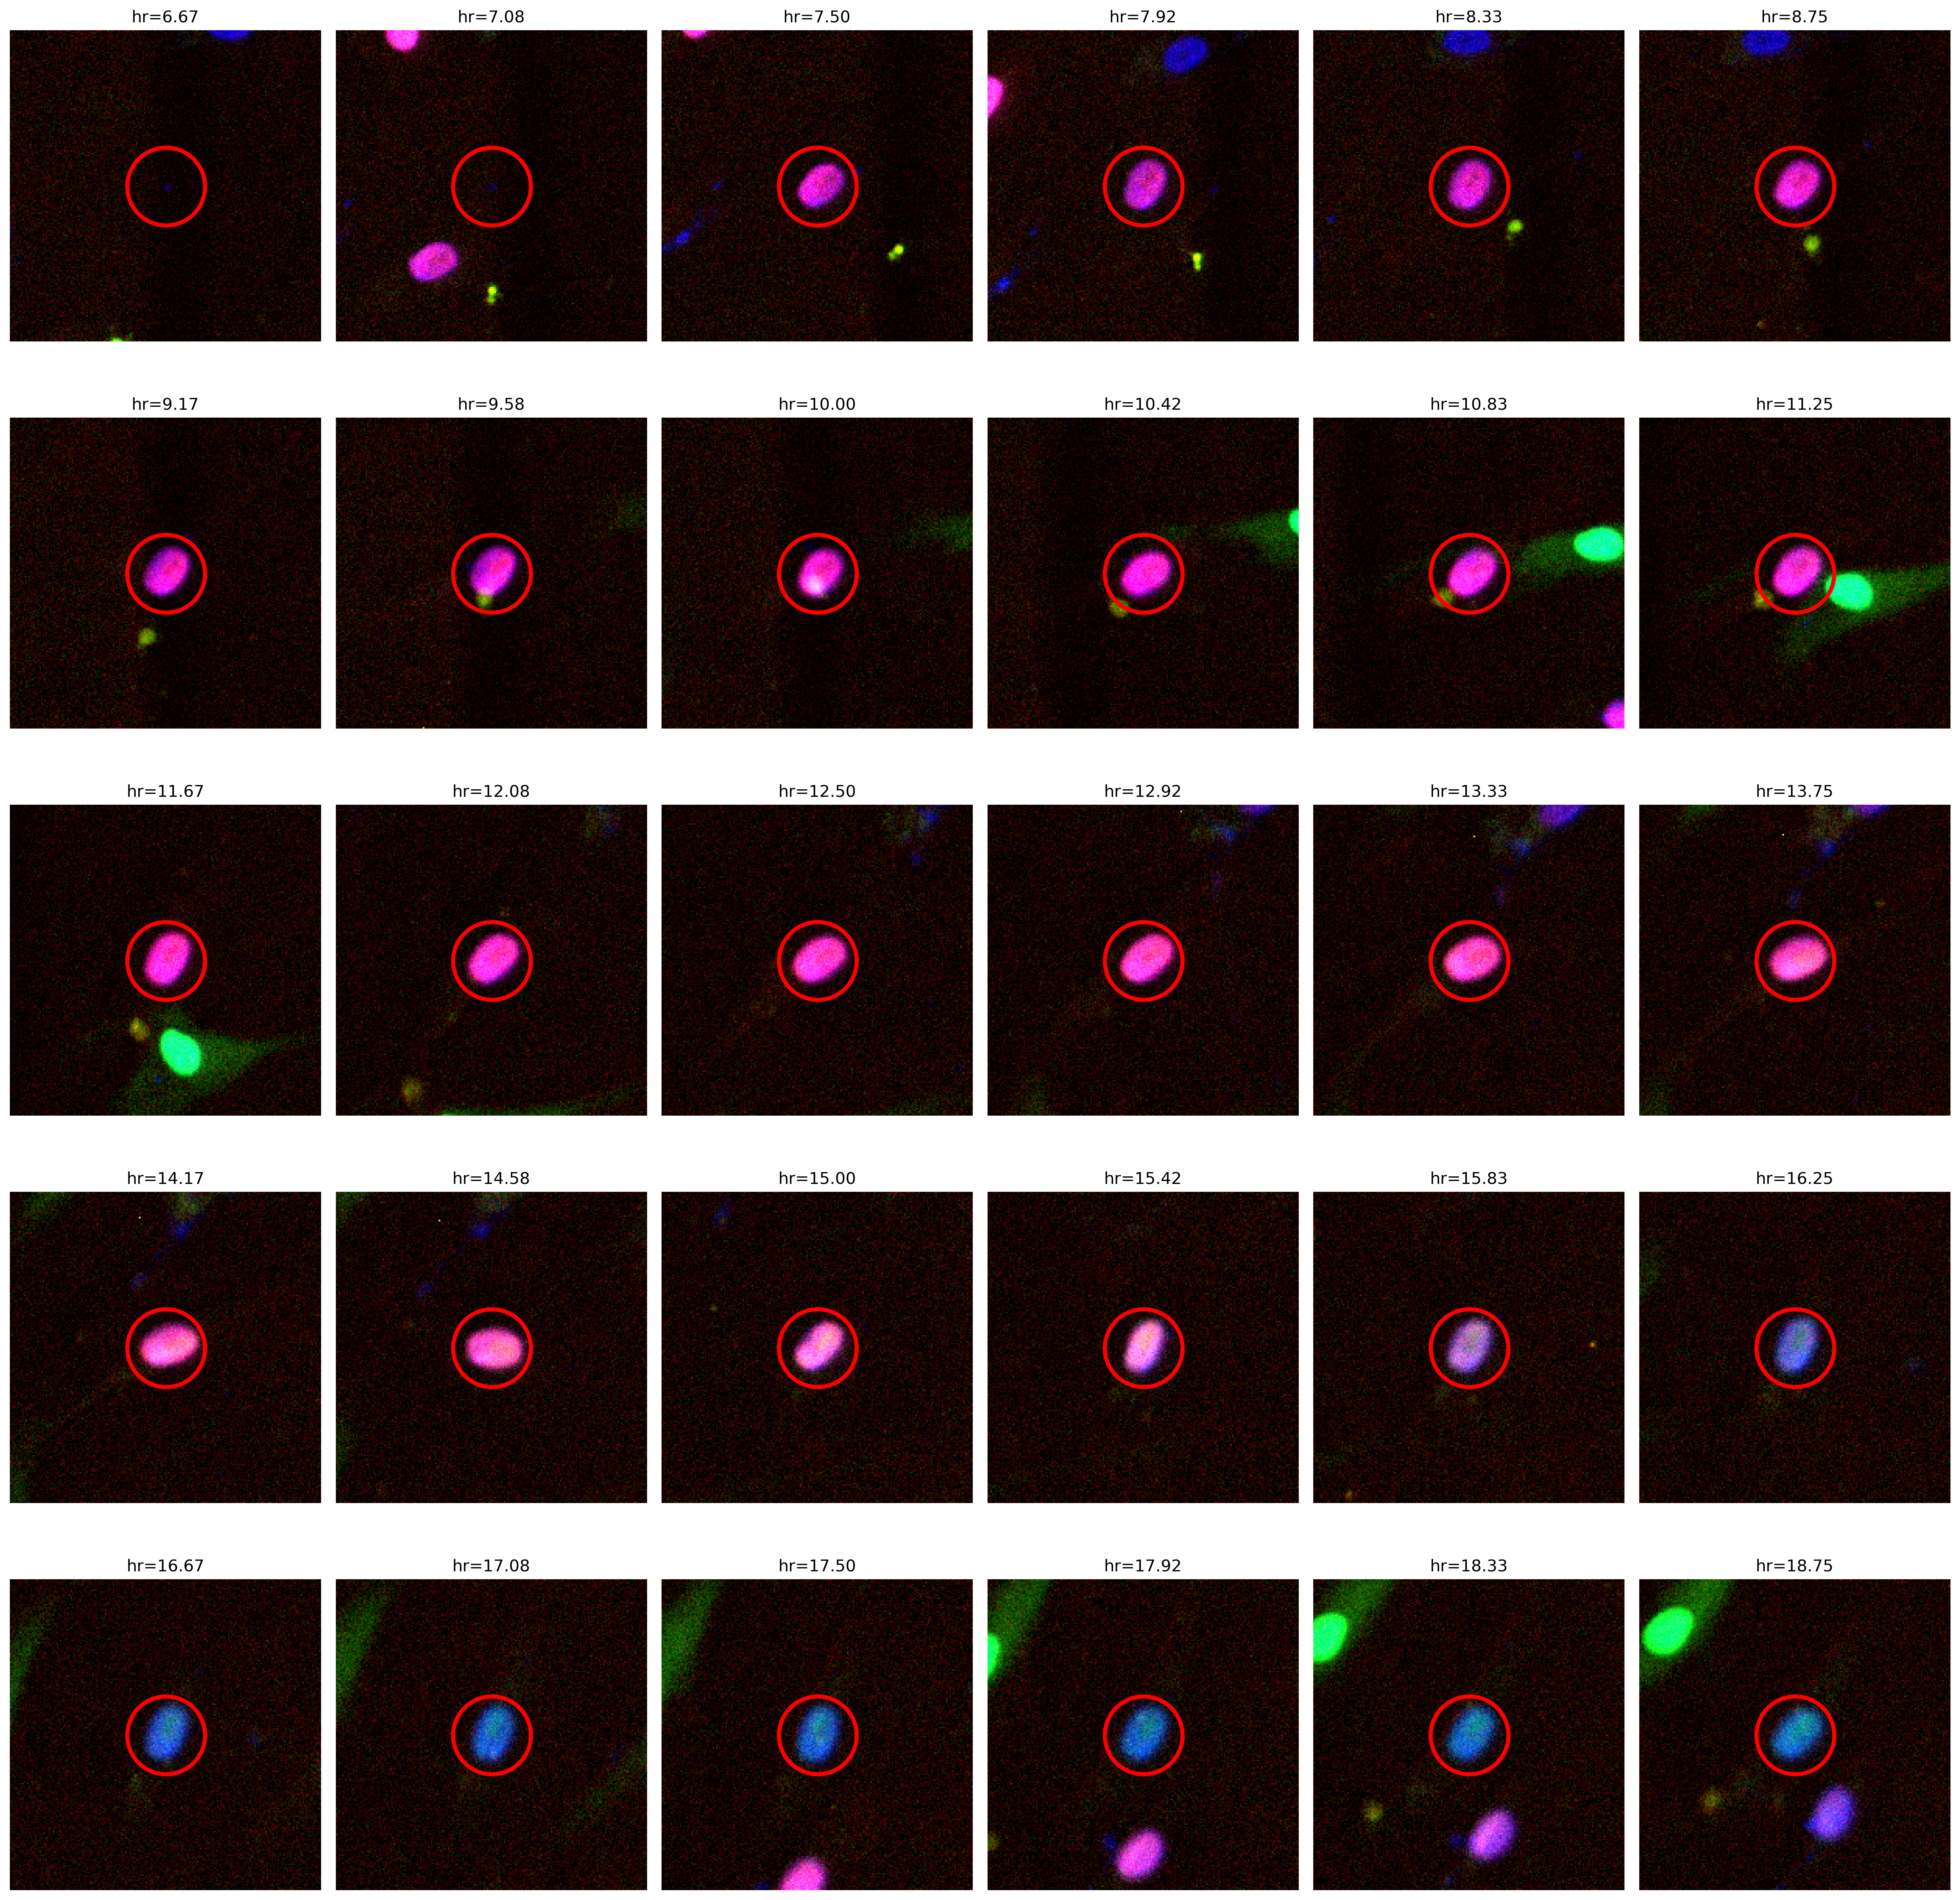

In [43]:
n_cols = 6
nucleus_size = 25

df['Time'] = (df['FRAME'] * MINUTES_PER_FRAME) / 60

# rand_track = np.random.choice(df['TRACK_ID'].unique(), 1)[0]

rand_track = 321
tmp = df[df['TRACK_ID'] == rand_track].reset_index()


print(f"{int(rand_track)=}")
print(f"{tmp.shape=}")

n_rows = (len(tmp) // n_cols)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 20, 20
fig, axs = plt.subplots(n_rows, n_cols)

xwin = 100
ywin = 100

row_counter = 0
col_counter = 0

for idx, row in tmp.iterrows():
    
    # I truncate the end if they aren't a complete row
    if idx < (n_cols * n_rows):
    
        xpos = row['POSITION_X'] * SCALING
        ypos = row['POSITION_Y'] * SCALING
        frame = row['FRAME']
        hr = row['Time']

        img, spot = get_images(tiff, frame, xpos, ypos, xwin, ywin)

#         axs[row_counter, col_counter].imshow(img[:, :, 2], aspect='equal', cmap='Blues')
        axs[row_counter, col_counter].imshow(img, aspect='equal')
        axs[row_counter, col_counter].axis('off')
        axs[row_counter, col_counter].set_title(f'{hr=:.2f}')

        
        spot_blob = plt.Circle(spot, nucleus_size, color='r', lw=3, fill=False)
        axs[row_counter, col_counter].add_patch(spot_blob)

        col_counter += 1

        if col_counter == n_cols:
            row_counter += 1
            col_counter = 0

fig.tight_layout()  
plt.show()
    

In [9]:
break

SyntaxError: 'break' outside loop (<ipython-input-9-6aaf1f276005>, line 1)

In [ ]:
# store images for annotation

OUTPUT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/annotations/"
SAMPLE_SIZE = 1 # this is the number of TRACKS to be sampled
xwin = 100
ywin = 100
nucleus_size = 30
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = 4,4

# will overwrite the dir each time
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# np.random.seed(0)
tracks = np.random.choice(df['TRACK_ID'].unique(), SAMPLE_SIZE)
tmp = df[df['TRACK_ID'].isin(tracks)]

last_track = None
for idx, row in tmp.iterrows():
    xpos = row['POSITION_X'] * SCALING
    ypos = row['POSITION_Y'] * SCALING
    
    if np.isnan(row['TRACK_ID']):
        continue
    
    frame = int(row['FRAME'])
    track = int(row['TRACK_ID'])
    
    if not track == last_track:
        print(f"{track=}")
    last_track = track
    
    # make sure we always have a left and right image

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # image under question 
    img, spot = get_images(tiff, frame, xpos, ypos, xwin, ywin)
    
    if len(img) == 0:
        continue
    
    ax1.imshow(img)
    ax1.axis('off')
    spot_blob = plt.Circle(spot, nucleus_size, color='r', fill=False)
    ax1.add_patch(spot_blob)
    
    ax2.imshow(img[:, :, 1], cmap='Greens')
    ax2.axis('off')
    spot_blob = plt.Circle(spot, nucleus_size, color='r', fill=False)
    ax2.add_patch(spot_blob)
    
    ax3.imshow(img[:, :, 0], cmap='Reds')
    ax3.axis('off')
    spot_blob = plt.Circle(spot, nucleus_size, color='r', fill=False)
    ax3.add_patch(spot_blob)
    
    plt.title(f"{track=}")
           
#     filename = f"track{track}_frame{frame}.png"
#     save_path = f"{OUTPUT_DIR}{filename}"
#     plt.savefig(save_path,  bbox_inches='tight')
#     plt.close(fig)
    
# print("Done.")

In [ ]:
# # store images for annotation

"""
These images are single composite channel, single time-point ordered along a track.
"""

# OUTPUT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/annotations/"
# SAMPLE_SIZE = 50 # this is the number of TRACKS to be sampled
# xwin = 100
# ywin = 100
# nucleus_size = 30
# plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = 3, 3

# # will overwrite the dir each time
# if os.path.exists(OUTPUT_DIR):
#     shutil.rmtree(OUTPUT_DIR)
# os.makedirs(OUTPUT_DIR)

# np.random.seed(0)
# tracks = np.random.choice(df['TRACK_ID'].unique(), SAMPLE_SIZE)
# tmp = df[df['TRACK_ID'].isin(tracks)]

# last_track = None
# for idx, row in tmp.iterrows():

    
#     xpos = row['POSITION_X'] * SCALING
#     ypos = row['POSITION_Y'] * SCALING
    
#     if np.isnan(row['TRACK_ID']):
#         continue
    
#     frame = int(row['FRAME'])
#     track = int(row['TRACK_ID'])
    
#     if not track == last_track:
#         print(f"{track=}")
#     last_track = track
    
#     # make sure we always have a left and right image

#     fig, (ax1) = plt.subplots(1)

#     # image under question 
#     img, spot = get_images(tiff, frame, xpos, ypos, xwin, ywin)
    
#     if len(img) == 0:
#         continue
    
#     ax1.imshow(img)
#     ax1.axis('off')
#     spot_blob = plt.Circle(spot, nucleus_size, color='r', fill=False)
#     ax1.add_patch(spot_blob)
#     ax1.set_title(f"{frame=} {track=}")
           
#     filename = f"track{track}_frame{frame}.png"
#     save_path = f"{OUTPUT_DIR}{filename}"
#     plt.savefig(save_path,  bbox_inches='tight')
#     plt.close(fig)
    
# print("Done.")

In [ ]:
# # store images for annotation

# SAMPLE_SIZE = 500 # this is the number of IMAGES to be sampled
# OUTPUT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/annotations/"
# xwin = 100
# ywin = 100
# nucleus_size = 30
# plt.rcParams['figure.dpi'] = 250

# # will overwrite the dir each time
# if os.path.exists(OUTPUT_DIR):
#     shutil.rmtree(OUTPUT_DIR)
# os.makedirs(OUTPUT_DIR)


# for idx, row in df.sample(SAMPLE_SIZE).iterrows():
    
#     xpos = row['POSITION_X'] * SCALING
#     ypos = row['POSITION_Y'] * SCALING
    
#     if np.isnan(row['TRACK_ID']):
#         continue
    
#     frame = int(row['FRAME'])
#     track = int(row['TRACK_ID'])
    
#     # make sure we always have a left and right image
#     if (frame > 2) and (frame < df['FRAME'].max() - 1):
#         fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
#         # preceeding image
#         prev_img, _ = get_images(tiff, frame - 1 , xpos, ypos, xwin, ywin)
#         ax1.imshow(prev_img)
#         ax1.axis('off')
#         ax1.set_title("T - 1")
        
#         # image under question 
#         img, spot = get_images(tiff, frame, xpos, ypos, xwin, ywin)
#         ax2.imshow(img)
#         ax2.axis('off')
#         spot_blob = plt.Circle(spot, nucleus_size, color='r', fill=False)
#         ax2.add_patch(spot_blob)
#         ax2.set_title("T")
        
#         # following image
#         post_img, _ = get_images(tiff, frame + 1 , xpos, ypos, xwin, ywin)
#         ax3.imshow(post_img)
#         ax3.axis('off')
#         ax3.set_title("T + 1")
        
#     filename = f"track{track}_frame{frame}.png"
#     save_path = f"{OUTPUT_DIR}{filename}"
#     plt.savefig(save_path,  bbox_inches='tight')
#     plt.close(fig)
#     print(f"{filename=}")

        
        
        
    